In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [3]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

print(avDev)

cuda


In [5]:
torch.manual_seed(1)
np.random.seed(1)

In [6]:
len(trainset)

50000

In [7]:
# STEP 2: MAKING DATASET ITERABLE
 
batch_size = 500
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=len(testset), 
                                          shuffle=False)
 

In [20]:
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 4000)
        self.linear1_drop = nn.Dropout(0.2)
        self.linear2 = nn.Linear(4000, 3000)
        self.linear2_drop = nn.Dropout(0.2)
        self.linear3 = nn.Linear(3000, output_dim)
        self.relu = nn.ReLU()
     
    def forward(self, x):
        out = self.relu(self.linear1(x))
        layer1_out = self.linear1_drop(out)
        out = self.relu(self.linear2(layer1_out))
        layer2_out = self.linear2_drop(out)
        out = self.linear3(layer2_out)
        return out
    

In [21]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 3*32*32
output_dim = 10
 
model = LogisticRegressionModel(input_dim, output_dim)

In [22]:
#  USE GPU FOR MODEL  #
#######################
 
model.to(avDev)
 
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss().to(avDev)


In [23]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.03
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

LogisticRegressionModel(
  (linear1): Linear(in_features=3072, out_features=4000, bias=True)
  (linear1_drop): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=4000, out_features=3000, bias=True)
  (linear2_drop): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=3000, out_features=10, bias=True)
  (relu): ReLU()
)


In [24]:
#L1, and L2 regularization parms

lambda1, lambda2 = 0.5, 0.1

In [25]:
'''
STEP 7: TRAIN THE MODEL
'''

loss_save = np.empty(n_iters-1)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        
        # Forward pass to get output/logits
        outputs = model(images)
#         outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        cross_entropy_loss = criterion(outputs, labels)#
        
        
        all_linear1_params = torch.cat([x.view(-1) for x in model.linear1.parameters()])
        all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()])
        l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
        l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)
        
        loss = cross_entropy_loss + l1_regularization + l2_regularization
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
           
        #Save Loss    
        
        loss_save[iter-1] = loss.item()
        iter += 1
        
        if iter % 200 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 3*32*32).to(avDev)
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (predicted.cpu() == labels.cpu()).sum().float()
             
            accuracy = 100. * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 200. Loss: 39904.44921875. Accuracy: 13.40999984741211
Iteration: 400. Loss: 39927.58984375. Accuracy: 14.770000457763672
Iteration: 600. Loss: 39962.1875. Accuracy: 16.860000610351562
Iteration: 800. Loss: 39997.5703125. Accuracy: 13.760000228881836
Iteration: 1000. Loss: 40034.2265625. Accuracy: 14.020000457763672
Iteration: 1200. Loss: 40068.16796875. Accuracy: 11.569999694824219
Iteration: 1400. Loss: 40115.15234375. Accuracy: 10.880000114440918
Iteration: 1600. Loss: 40159.296875. Accuracy: 10.90999984741211
Iteration: 1800. Loss: 40196.015625. Accuracy: 12.90999984741211
Iteration: 2000. Loss: 40229.3125. Accuracy: 14.649999618530273
Iteration: 2200. Loss: 40262.625. Accuracy: 12.520000457763672
Iteration: 2400. Loss: 40299.80078125. Accuracy: 12.170000076293945
Iteration: 2600. Loss: 40340.8359375. Accuracy: 12.329999923706055
Iteration: 2800. Loss: 40380.76953125. Accuracy: 15.970000267028809
Iteration: 3000. Loss: 40418.60546875. Accuracy: 12.680000305175781
Iterati

In [26]:
correct = 0
total = 0
model.to(avDev)

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  train images: 16 %


In [27]:
print(images.size())

torch.Size([500, 3072])


In [28]:
outputs.size()

torch.Size([500, 10])

In [29]:
labels.size()

torch.Size([500])

# Learning Curve

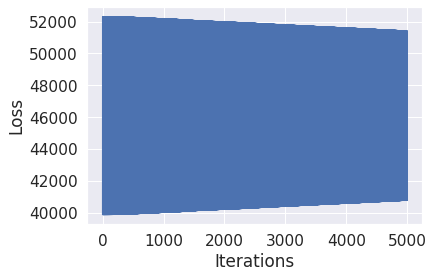

In [30]:
ax = sns.lineplot(data = loss_save)
ax.set(xlabel = "Iterations", ylabel="Loss")
plt.show()

# Confusion Matrix

In [31]:
model.to(avDev)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
cm = confusion_matrix(predicted.cpu(), labels.cpu()).astype(np.int)

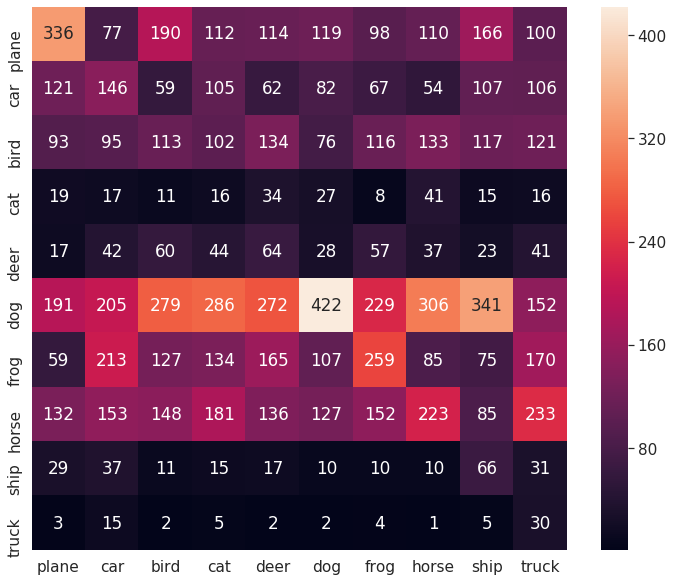

In [32]:
import pandas as pd
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(12,10))
df_cm = pd.DataFrame(cm,CLASSES,CLASSES)
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,annot=True,fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()